In [8]:
from pynq import Overlay
from pynq import MMIO
import xrfclk
import xrfdc
import struct
from time import sleep
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal

In [9]:
# FIRMWARE UPLOAD
firmware = Overlay("tetra_v3p4.bit",ignore_version=True)

# INITIALIZING PLLs
clksrc = 409.6 # MHz
xrfclk.set_all_ref_clks(clksrc)

In [10]:
# SET ETHERNET IPS and MACS
def ethRegsPortWrite(eth_regs,
                     src_ip_int32   = int("c0a80335",16),
                     dst_ip_int32   = int("c0a8032a",16), # 192.168.2.42
                     src_mac0_int32 = int("eec0ffee",16),
                     src_mac1_int16 = int("c0ff",16),
                     dst_mac0_int16 = int("41bf",16),  # last four hex of mac   # 3c:7c:3f:5d: 41:bf
                     dst_mac1_int32 = int("3c7c3f5d",16)): # first eight hex of mac
    eth_regs.write( 0x00, src_mac0_int32) 
    eth_regs.write( 0x04, (dst_mac0_int16<<16) + src_mac1_int16)
    eth_regs.write( 0x08, dst_mac1_int32)
    eth_regs.write( 0x0c, src_ip_int32)
    eth_regs.write( 0x10, dst_ip_int32)
    
ethRegsPortWrite(firmware.ethWrapPort0.eth_regs_0, src_ip_int32=int("c0a80332",16))
ethRegsPortWrite(firmware.ethWrapPort1.eth_regs_0, src_ip_int32=int("c0a80333",16))
ethRegsPortWrite(firmware.ethWrapPort2.eth_regs_0, src_ip_int32=int("c0a80334",16))
ethRegsPortWrite(firmware.ethWrapPort3.eth_regs_0, src_ip_int32=int("c0a80335",16))

In [15]:
# Functions

def set_NCLO( chan, lofreq):

    import xrfdc
    rf_data_conv = firmware.usp_rf_data_converter_0
    
    if chan == 1:
        rf_data_conv.adc_tiles[0].blocks[0].MixerSettings['Freq']=lofreq
        rf_data_conv.dac_tiles[1].blocks[3].MixerSettings['Freq']=lofreq
        rf_data_conv.adc_tiles[0].blocks[0].UpdateEvent(xrfdc.EVENT_MIXER)
        rf_data_conv.dac_tiles[1].blocks[3].UpdateEvent(xrfdc.EVENT_MIXER)
    elif chan == 2:
        rf_data_conv.adc_tiles[0].blocks[1].MixerSettings['Freq']=lofreq
        rf_data_conv.dac_tiles[1].blocks[2].MixerSettings['Freq']=lofreq
        rf_data_conv.adc_tiles[0].blocks[1].UpdateEvent(xrfdc.EVENT_MIXER)
        rf_data_conv.dac_tiles[1].blocks[2].UpdateEvent(xrfdc.EVENT_MIXER)
    elif chan == 3:
        rf_data_conv.adc_tiles[1].blocks[0].MixerSettings['Freq']=lofreq
        rf_data_conv.dac_tiles[1].blocks[1].MixerSettings['Freq']=lofreq
        rf_data_conv.adc_tiles[1].blocks[0].UpdateEvent(xrfdc.EVENT_MIXER)
        rf_data_conv.dac_tiles[1].blocks[1].UpdateEvent(xrfdc.EVENT_MIXER)
    elif chan == 4:
        rf_data_conv.adc_tiles[1].blocks[1].MixerSettings['Freq']=lofreq
        rf_data_conv.dac_tiles[1].blocks[0].MixerSettings['Freq']=lofreq
        rf_data_conv.adc_tiles[1].blocks[1].UpdateEvent(xrfdc.EVENT_MIXER)
        rf_data_conv.dac_tiles[1].blocks[0].UpdateEvent(xrfdc.EVENT_MIXER)
    else:
        return "Does not compute"
    return
   
def generate_wave_ddr4(freq_list):    
    fs = 512e6 
    lut_len = 2**20
    fft_len = 1024
    k = np.int64(np.round(freq_list/(fs/lut_len)))
    freq_actual = k*(fs/lut_len)
    X = np.zeros(lut_len,dtype='complex')
    phi = np.random.uniform(-np.pi, np.pi, np.size(freq_list))
    X[k] = np.exp(-1j*phi)
    x = np.fft.ifft(X) * lut_len/np.sqrt(2)
    bin_num = np.int64(np.round(freq_actual / (fs / fft_len)))
    f_beat = bin_num*fs/fft_len - freq_actual
    dphi0 = f_beat/(fs/fft_len)*2**16
    if np.size(dphi0) > 1:
        dphi = np.concatenate((dphi0, np.zeros(fft_len - np.size(dphi0))))
    else:
        z = np.zeros(fft_len)
        z[0] = dphi0
        dphi = z
    return x, dphi, freq_actual

def norm_wave(wave, max_amp=2**15-1):
    norm = np.max(np.abs(wave))
    if norm == 0:
        return wave.real, wave.imag
    wave_real = ((wave.real/norm)*max_amp).astype("int16")
    wave_imag = ((wave.imag/norm)*max_amp).astype("int16")
    return wave_real, wave_imag

def load_bin_list(chan, freq_list):
    fs = 512e6
    fft_len = 1024
    lut_len = 2**20
    k = np.int64(np.round(-freq_list/(fs/lut_len)))
    freq_actual = k*(fs/lut_len)
    bin_list = np.int64(np.round(freq_actual / (fs / fft_len)))
    pos_bin_idx = np.where(bin_list > 0)
    if np.size(pos_bin_idx) > 0:
        bin_list[pos_bin_idx] = 1024 - bin_list[pos_bin_idx]
    bin_list = np.abs(bin_list)
    # DSP REGS
    if chan == 1:
        dsp_regs = firmware.chan1.dsp_regs_0
    elif chan == 2:
        dsp_regs = firmware.chan2.dsp_regs_0
    elif chan == 3:
        dsp_regs = firmware.chan3.dsp_regs_0
    elif chan == 4:
        dsp_regs = firmware.chan4.dsp_regs_0
    else:
        return "Does not compute"
    # 0x00 -  fft_shift[9 downto 0], load_bins[22 downto 12], lut_counter_rst[11 downto 11] 
    # 0x04 -  bin_num[9 downto 0]
    # 0x08 -  accum_len[23 downto 0], accum_rst[24 downto 24], sync_in[26 downto 26] (start dac)
    # 0x0c -  dds_shift[8 downto 0]
    
    # initialization 
    sync_in = 2**26
    accum_rst = 2**24  # (active low)
    accum_length = (2**19)-1
    ################################################
    # Load DDC bins
    ################################################
    offs=0
    
    # only write tones to bin list
    for addr in range(1024):
        if addr<(np.size(bin_list)):
            #print("addr = {}, bin# = {}".format(addr, bin_list[addr]))
            dsp_regs.write(0x04,int(bin_list[addr]))
            dsp_regs.write(0x00, ((addr<<1)+1)<<12)
            dsp_regs.write(0x00, 0)
        else:
            dsp_regs.write(0x04, 0)
            dsp_regs.write(0x00, ((addr<<1)+1)<<12)
            dsp_regs.write(0x00, 0)
    return

def reset_accum_and_sync(chan, freqs):
    if chan == 1:
        dsp_regs = firmware.chan1.dsp_regs_0
    elif chan == 2:
        dsp_regs = firmware.chan2.dsp_regs_0
    elif chan == 3:
        dsp_regs = firmware.chan3.dsp_regs_0
    elif chan == 4:
        dsp_regs = firmware.chan4.dsp_regs_0
    else:
        return "Does not compute"
    # dsp_regs bitfield map
    # 0x00 -  fft_shift[9 downto 0], load_bins[22 downto 12], lut_counter_rst[11 downto 11] 
    # 0x04 -  bin_num[9 downto 0]
    # 0x08 -  accum_len[23 downto 0], accum_rst[24 downto 24], sync_in[26 downto 26] (start dac)
    # 0x0c -  dds_shift[8 downto 0]
    # initialization
    sync_in = 2**26
    accum_rst = 2**24  # (active rising edge)
    accum_length = (2**19)-1#(2**19)-1 # (2**18)-1
    
    fft_shift=0
    if len(freqs)<400:
        fft_shift = 2**9-1 #2**9-1
    else:
        fft_shift = 2**2-1 #2**2-1
    dsp_regs.write(0x00, fft_shift) # set fft shift
    ########################
    dsp_regs.write(0x08, accum_length | sync_in)
    sleep(0.5)
    dsp_regs.write(0x08, accum_length | accum_rst | sync_in)
    dsp_regs.write(0x0c,260)
    return

def load_ddr4(chan, wave_real, wave_imag, dphi):
    if chan == 1:
        base_addr_dphis = 0xa004c000
    elif chan == 2:
        base_addr_dphis = 0xa0040000
    elif chan == 3:
        base_addr_dphis = 0xa0042000
    elif chan == 4:
        base_addr_dphis = 0xa004e000
    else:
        return "Does not compute"
    
    # write dphi to bram
    dphi_16b = dphi.astype("uint16")
    dphi_stacked = ((np.uint32(dphi_16b[1::2]) << 16) + dphi_16b[0::2]).astype("uint32")
    mem_size = 512 * 4 # 32 bit address slots
    mmio_bram_phis = MMIO(base_addr_dphis, mem_size)
    mmio_bram_phis.array[0:512] = dphi_stacked[0:512] # the [0:512] indexing is necessary on .array
    
    # slice waveform for uploading to ddr4
    Q0, Q1, Q2, Q3 = wave_real[0::4], wave_real[1::4], wave_real[2::4], wave_real[3::4]
    I0, I1, I2, I3 = wave_imag[0::4], wave_imag[1::4], wave_imag[2::4], wave_imag[3::4]
    data0 = ((np.int32(I0) << 16) + Q0).astype("int32")
    data1 = ((np.int32(I1) << 16) + Q1).astype("int32")
    data2 = ((np.int32(I2) << 16) + Q2).astype("int32")
    data3 = ((np.int32(I3) << 16) + Q3).astype("int32")
    # write waveform to DDR4 memory
    ddr4mux = firmware.axi_ddr4_mux
    ddr4mux.write(8,0) # set read valid 
    ddr4mux.write(0,0) # mux switch
    ddr4 = firmware.ddr4_0
    base_addr_ddr4 = 0x4_0000_0000 #0x5_0000_0000
    depth_ddr4 = 2**32
    mmio_ddr4 = MMIO(base_addr_ddr4, depth_ddr4)
    mmio_ddr4.array[0:4194304][0 + (chan-1)*4::16] = data0
    mmio_ddr4.array[0:4194304][1 + (chan-1)*4::16] = data1
    mmio_ddr4.array[0:4194304][2 + (chan-1)*4::16] = data2
    mmio_ddr4.array[0:4194304][3 + (chan-1)*4::16] = data3
    ddr4mux.write(8,1) # set read valid 
    ddr4mux.write(0,1) # mux switch
    return

# capture data from ADC
def get_snap_data(chan, mux_sel):
    # WIDE BRAM
    if chan==1:
        axi_wide = firmware.chan1.axi_wide_ctrl# 0x0 max count, 0x8 capture rising edge trigger
        base_addr_wide = 0x00_A007_0000
    elif chan==2:
        axi_wide = firmware.chan2.axi_wide_ctrl
        base_addr_wide = 0x00_B000_0000
    elif chan==3:
        axi_wide = firmware.chan3.axi_wide_ctrl
        base_addr_wide = 0x00_B000_8000
    elif chan==4:
        axi_wide = firmware.chan4.axi_wide_ctrl
        base_addr_wide = 0x00_8200_0000
    else:
        return "Does not compute"
    max_count = 32768
    axi_wide.write(0x08, mux_sel<<1) # mux select 0-adc, 1-pfb, 2-ddc, 3-accum
    axi_wide.write(0x00, max_count - 16) # -4 to account for extra delay in write counter state machine
    #axi_wide.write(0x08, mux_sel<<1 | 0)
    axi_wide.write(0x08, mux_sel<<1 | 1)
    #axi_wide.write(0x08, mux_sel<<1 | 0)
    mmio_wide_bram = MMIO(base_addr_wide,max_count)
    wide_data = mmio_wide_bram.array[0:8192]# max/4, bram depth*word_bits/32bits
    if mux_sel==0:
        #adc parsing
        up0, lw0 = np.int16(wide_data[0::4] >> 16), np.int16(wide_data[0::4] & 0x0000ffff)
        up1, lw1 = np.int16(wide_data[1::4] >> 16), np.int16(wide_data[1::4] & 0x0000ffff)
        I = np.zeros(4096)
        Q = np.zeros(4096)
        Q[0::2] = lw0
        Q[1::2] = up0
        I[0::2] = lw1
        I[1::2] = up1
    elif mux_sel==1:
        # pfb
        chunk0 = (np.uint64(wide_data[1::4]) << np.uint64(32)) + np.uint64(wide_data[0::4])
        chunk1 = (np.uint64(wide_data[2::4]) << np.uint64(32)) + np.uint64(wide_data[1::4])
        q0 = np.int64((chunk0 & 0x000000000003ffff)<<np.uint64(46))/2**32
        i0 = np.int64(((chunk0>>18) & 0x000000000003ffff)<<np.uint64(46))/2**32
        q1 = np.int64(((chunk1>>4)  & 0x000000000003ffff)<<np.uint64(46))/2**32
        i1 = np.int64(((chunk1>>22)  & 0x000000000003ffff)<<np.uint64(46))/2**32
        I = np.zeros(4096)
        Q = np.zeros(4096)
        Q[0::2] = q0/2**14
        Q[1::2] = q1/2**14
        I[0::2] = i0/2**14
        I[1::2] = i1/2**14
    elif mux_sel==2:
        # ddc
        chunk0 = (np.uint64(wide_data[1::4]) << np.uint64(32)) + np.uint64(wide_data[0::4])
        chunk1 = (np.uint64(wide_data[2::4]) << np.uint64(32)) + np.uint64(wide_data[1::4])
        q0 = np.int64((chunk0 & 0x00000000000fffff)<<np.uint64(45))/2**32
        i0 = np.int64(((chunk0>>19) & 0x00000000000fffff)<<np.uint64(45))/2**32
        q1 = np.int64(((chunk1>>6)  & 0x00000000000fffff)<<np.uint64(45))/2**32
        i1 = np.int64(((chunk1>>25)  & 0x00000000000fffff)<<np.uint64(45))/2**32
        I = np.zeros(4096)
        Q = np.zeros(4096)
        Q[0::2] = q0/2**13
        Q[1::2] = q1/2**13
        I[0::2] = i0/2**13
        I[1::2] = i1/2**13
    elif mux_sel==3:
        # accum
        q0 = (np.int32(wide_data[1::4])).astype("float")
        i0 = (np.int32(wide_data[0::4])).astype("float")
        q1 = (np.int32(wide_data[3::4])).astype("float")
        i1 = (np.int32(wide_data[2::4])).astype("float")
        I = np.zeros(4096)
        Q = np.zeros(4096)
        Q[0::2] = q0
        Q[1::2] = q1
        I[0::2] = i0
        I[1::2] = i1    
    return I, Q

In [16]:
freqs_requested = np.array(np.linspace(-254.4e6, 255.00e6, 1000))
wave, dphi, freq_actual = generate_wave_ddr4(freqs_requested);
wave_real, wave_imag = norm_wave(wave, max_amp=2**15-1)
load_ddr4( 1, wave_real, wave_imag, dphi)
load_bin_list( 1, freq_actual)
reset_accum_and_sync( 1, freq_actual)

In [17]:
 set_NCLO( 1, 500) # chan, LO freq [MHz]

<IPython.core.display.Javascript object>


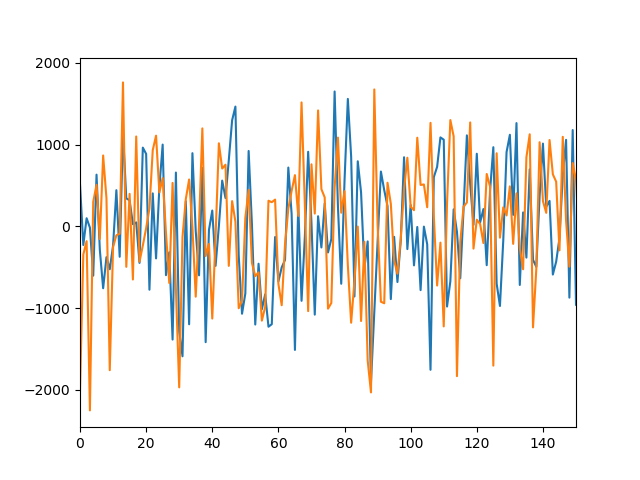

<IPython.core.display.Javascript object>


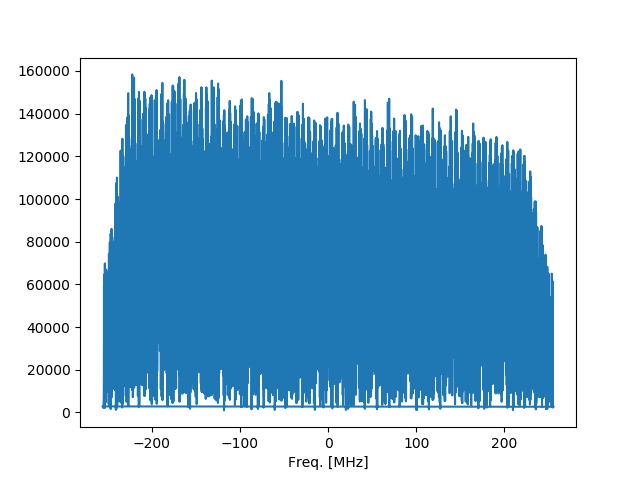

In [138]:
I, Q = get_snap_data(1, 0)
c = slice(3750,4096)
plt.figure()
plt.plot(I[c])
plt.plot(Q[c])
#plt.plot(np.sqrt(I[c]**2 + Q[c]**2))
plt.xlim(0,150)
spec = np.fft.fft(I + 1j*Q)
s_freq = np.fft.fftfreq(len(I),d=1./512e6)
plt.figure()
plt.plot(s_freq/1e6, np.abs(spec))
plt.xlabel("Freq. [MHz]")
plt.show()

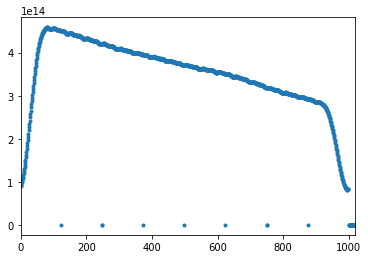

In [19]:
# PFB spectra
I, Q = get_snap_data(1, 3)
plt.figure()
plt.plot(I[4:]**2 + Q[4:]**2, '.')
plt.xlim(0,1020)
plt.show()

In [18]:
# write phase freqs to ddc luts
# DDS shift debug loop
#for step in range(512):
#    firmware.chan1.dsp_regs_0.write(0x0c,step) # WRITING TO DDS SHIFT 
#    sleep(.1)
#    I, Q = get_snap_data(1, 3)
#    IQddc=np.abs(I[0:1024].astype("float")+1j*Q[0:1024].astype("float"))
#    peak=IQddc[np.argmax(IQddc[:1024])]
#    print(step, peak)